# FYD 600: Introduction to deep learning and reinforcement learning
#### Authors: Oleksandr Balabanov, Jonatan Wårdh, Mats Granath, Shahnawaz Ahmed 
(2019, revised 2020.)

# Handout 2: Supervised learning using Keras/TensorFlow

In this project we will continue the application of neural networks for supervised learning, now for image recognition. We will use [Keras](https://keras.io/), an API for implementing neural networks, which uses [TensorFlow](https://www.tensorflow.org/) as it's backbone. You will learn basics of the most common techniques used in image recognition and how to apply them using Keras. As an example we will consider the [Fashion MNIST](http://yann.lecun.com/exdb/mnist/) dataset of images of individual articles of clothing . This dataset is one of the benchmark problems in image recognition. The homework project will be on the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) data set of images which consists of 10 classes of 32$\times$32 RGB images.

## Background

In the first handout you have learned how to use neural networks for simple task of two-dimensional data classification. You have been introduced to concepts of supervised learning, network layers, activation functions, forward-propagation, backward-propagation, cost function, and others. In the assignment, you were asked to implement fully-connected neural networks with one and two hidden layers and classify some simple non-linearly seperable data. Despite the simplicity of those networks, to program the back propagation algorithm needed for gradient descent training of the network parameters can be challenging. 

Clearly, the simple network architecture that was used will be effective in more realistic classification problems. Deeper networks and more sophisticated layers, as well as cost and activation functions have to be introduced. There is a good news though: nowadays you do not need to write your code from scratch and can use one of the open source environments containing most of the needed tools. One of the most popular such environments is Keras, typically with Tensorflow as backbone. (Keras is a set of extra functionality that calls the Tensorflow routines.) We highlight one more time that Keras and Tensorflow are just tools for implementing neural networks and to effectively employ it you will need to learn some extra aspects of the neural networks in addition to material from the handout 1. 

First of all, let us import [TensorFlow](https://www.tensorflow.org/) and its higher level API [Keras](https://keras.io/). 

The instructional code in this Handout is based on Keras as an external module using Tensorflow 1.x. If you run tensorflow 2 you don't need to import Keras, as it's built in. If so you should run Keras commands as <code>tf.keras...</code>. But it's back compatible, so the provided code should function as is also with tf 2. 

In [1]:
# TensorFlow and tf.keras use it to import mnist data 
import tensorflow as tf
from tensorflow import keras  

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

1.8.0


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12019532562867987975
]


Both [Keras](https://keras.io/) and [TensorFlow](https://www.tensorflow.org/) have their own database of tutorials. They are quite complete and well written. For our project the ambition is to narrow down to a subset of layers and functions and quite quickly progress to the calculations. The tutorials can be used for more indepth coverage.    

It is always easier to learn on a concrete example. There are quite a few databases available for direct import from Keras or TensorFlow. Most of them are well known databases of images used as benchmark sets in classification problems. We chose to first present a dataset called [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist). It contains 70,000 28 by 28 uint8 grayscale images of individual articles of clothing classified in 10 categories.

## First glance at Fashion MNIST

 Let us import Fashion MNIST dataset:

In [3]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 7s 2us/step


The pairs of data <code>(train_images, train_labels)</code> and <code>(test_images, test_labels)</code> are the images  and corresponding to those images category labels. The categories are labeled by integers from 0 to 9 and each this number corresponds to the following piece of clothing, collected in a list: 

In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

We use the training imageset to train our network and then test it on the test data in the very end of the procedure. It is assumed that we do not have access to the test data at any stage of the training and in this way we simulate realistic conditions for image recognition used in daily use applications. 

We find it instructive here to work a little bit on the just downloaded datasets. First, we check the dimensionality of the arrays and verify that there are 60,000 images in the training set and 10,000 images in the test set:

In [5]:
print(train_images.shape)
print(test_images.shape)
print(train_labels.shape)
print(test_labels.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


One can also plot any image from the dataset (vary the value of <code>image_number</code>) and verify that it indeed corresponds to the correct category, illustrated on the x-axis:

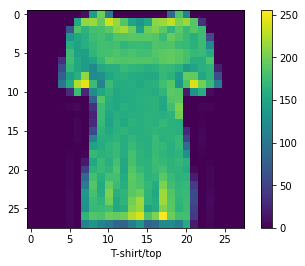

In [6]:
image_number = 10;

plt.figure()
#plt.imshow(train_images[image_number],cmap='gray')
plt.imshow(train_images[image_number])
plt.colorbar()
plt.xlabel(class_names[train_labels[image_number]])
plt.grid(False)

## Preprocessing

It is a common practice to do some short preproccesing procedure of the images before feeding them to the network. This is done for obtaining better performance. To begin with, we rescale the uint8 grayscale images into arrays of real numbers between 0 and 1, to avoid working with too large numbers. (That would require the weights and biases of the network to scale in proportion.) 

In [7]:
train_images_scaled = train_images / 255.0

test_images_scaled = test_images / 255.0

The dataset is then normalized by subtracting mean value over all training images:

In [8]:
# calculate mean value over all training data 
train_mean_single = np.average(train_images_scaled, axis=0)

size_train = train_images.shape[0]
size_test = test_images.shape[0]

# repeat the structure 60000 and 10000 times respectively
#train_mean = np.array([train_mean_single for i in range(size_train)])
#test_mean = np.array([train_mean_single for i in range(size_test)])

# Can only use broadcasting instead of for loops 
train_mean = np.array(train_mean_single)[np.newaxis,:,:]
test_mean = np.array(train_mean_single)[np.newaxis,:,:]

# subtract mean
train_images_scaled = np.subtract(train_images_scaled, train_mean)
test_images_scaled = np.subtract(test_images_scaled, test_mean)

Let us plot some of the images and see how they have transformed after the preprocessing procedure: 

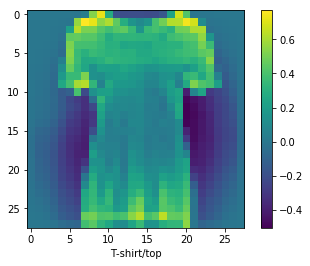

In [9]:
plt.figure()
plt.imshow(train_images_scaled[image_number])
plt.colorbar()
plt.xlabel(class_names[train_labels[image_number]])
plt.grid(False)

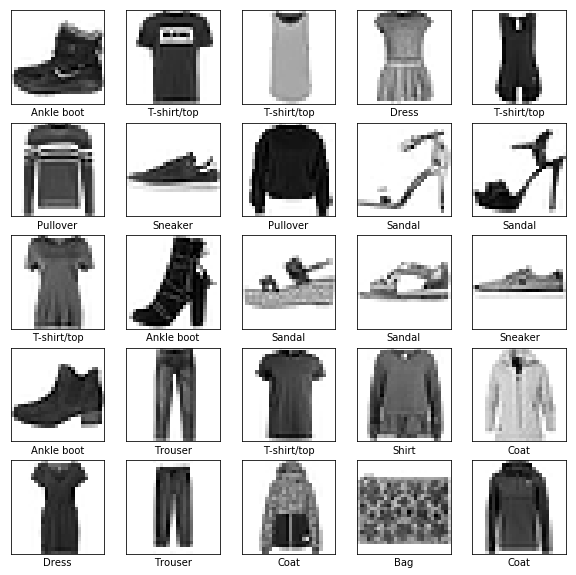

In [10]:
#Some additional examples
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])

## The architecture of a simple fully-connected network within Keras syntax 

To begin with, let us import all different elements of neural networks to our Python environment. At this stage you don't need to worry that you do not understand most of the packages to be imported. We will go through them one by one later in the handout.

In [11]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, Dropout, AveragePooling2D
from tensorflow.python.keras.callbacks import Callback
from tensorflow.python.keras import regularizers

Let us first take a glance at the example of a simple network given on [the official tutorial resource of TensorFlow](https://www.tensorflow.org/tutorials/keras/basic_classification) and look at different elements used in it in more details. As a beginning step we have to define a network object:

In [12]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

Here, the object <code>model</code> is a sequential network, meaning that it is composed of a sequence of connected layers. First layer, <code>Flatten</code>, is a trivial layer that flatters input data into a linear array. The next two layers <code>Dense</code> are fully connected layers that you have encountered already in the first handout. The argument <code>activation</code> specifies the activation function of the layer: so far you have seen just $\text{tahn}(a)$ activations but other more complicated functions may be used. More on this later. An equaivalent, but perhaps nicer syntax is the following:

In [13]:
model = Sequential()
model.add(Flatten(input_shape=(28, 28)))
model.add(Dense(128, activation="relu"))
model.add(Dense(10, activation="softmax"))

We now have to specify some general settings used in the training by using <code>compile</code> attribute:

In [14]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Here we specify the training method (<code>optimizer</code>), the loss function (<code>loss</code>), and the so-called <code>metric</code>, a function that is used by us for estimating the network's performance (it is not used for training). Most commonly, for training networks in image classification applications we use the Adam optimization algorithm, denoted by the name <code>AdamOptimizer</code>. It is an extension to stochastic gradient descent. The loss function <code>sparse_categorical_crossentropy</code> used here is also more sophisticated than the squared error loss function encountered by you in the first handout. It is quite important and it will be discussed in details in the next section. 

Finally, we train the network using <code>fit(train_images, train_labels, epochs = 5)</code>. It can take several parameters as arguments: <code>train_images</code> is the training dataset, <code>train_labels</code> are the corresponding labels, and <code>epochs = 5</code> sets the number of training epochs to 5. <code>fit</code> can take more parameters as input and we comment on them later. 

In [15]:
model.fit(train_images_scaled, train_labels, epochs = 5)

Epoch 1/5
60000/60000 [==============================] - 10s 163us/step - loss: 0.4357 - acc: 0.8439
Epoch 2/5
60000/60000 [==============================] - 9s 149us/step - loss: 0.3308 - acc: 0.8803
Epoch 3/5
60000/60000 [==============================] - 9s 143us/step - loss: 0.2929 - acc: 0.8914
Epoch 4/5
60000/60000 [==============================] - 13s 216us/step - loss: 0.2679 - acc: 0.9019
Epoch 5/5
60000/60000 [==============================] - 12s 193us/step - loss: 0.2465 - acc: 0.90931s - l


and we then may apply <code>model.evaluate</code> to test our trained network

In [16]:
test_loss, test_acc = model.evaluate(test_images_scaled, test_labels)

print('Test accuracy:', test_acc)

10000/10000 [==============================] - 1s 92us/step
Test accuracy: 0.8804


This shows the loss and accuracy of our network on the test data. (Note that the accuracy is lower on the test data than on the training data.)  

In [17]:
#network predicted output label, in terms of a probability  
predictions = model.predict(test_images_scaled)

In [18]:
#Some functions to facilitate plotting
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

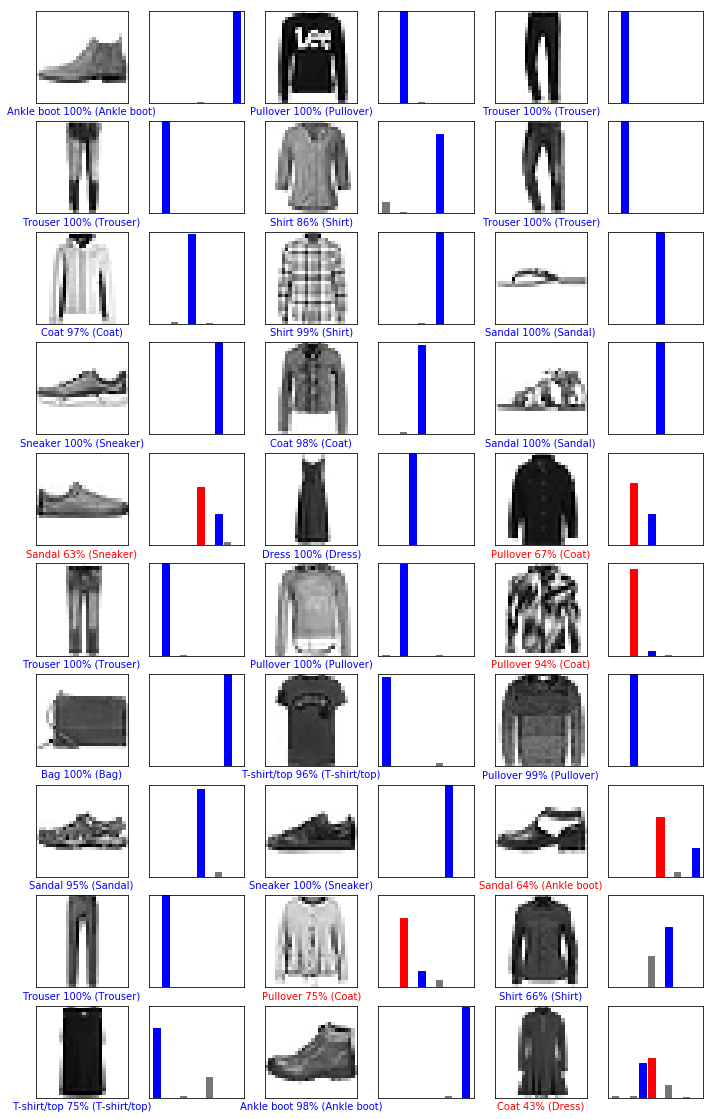

In [19]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red 
num_rows = 10
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

Blue is correct prediction of class, red is wrong. The bars to the right of the images represents the output from the network, and corresponds roughly to a probability distribution of classes according to the network. (To be discussed shortly.) 

_Now, we go through some important concepts needed for reaching good performance in image classification problems, or more generally, in supervised learning._  

## The Adam Optimization Algorithm

The training is usually done through Adam optimization algorithm. The name Adam is derived from adaptive moment estimation and it is an extension of the stochastic gradient descent that you saw in the previous handout. Adam has proven to be very effective in practice and that is why nowadays it is widely used in classification problems.  Without going into any details Adam assigns individual learning rates to distinct variational parameters (weights, thresholds) and optimizes the training: it automatically decreases the learning rates of noisy variational parameters, i.e. parameters with large derivative variations. For more details take a look at the original research [paper](https://arxiv.org/pdf/1412.6980.pdf), or the Keras or Tensorflow documentation.

## Cross-Entropy and Soft-Max

Even though the squared error loss function is probably the easiest choice for the loss function and it has been shown to be quite effective for simple classification tasks, it is actually not so efficient for classifying more complicated datasets. A more effective way to do the training is to employ the so-called [cross-entropy](https://en.wikipedia.org/wiki/Cross_entropy) loss function in combination with the so-called [softmax activations](https://en.wikipedia.org/wiki/Softmax_function) in the output layer. The softmax outputs are defined as follows

$$h^{(l)}_i = g(\,\vec{a}^{l})= \frac{e^{\, \lambda a^{l}_i}}{\sum_{i=1}^{M}e^{\, \lambda a^{l}_i}},$$

where we use the same notations as in the first handout  $a^{l}_i = \sum_{j} w^{l}_{ij} h^{l-1}_j - b^{l}_i$. Here $M$ is number of neurons in layer $l$, and $\lambda>0$ is a tunable parameter. Note that in contrast to the common type of activation function which only acts on a single node, $h_i^l=g(a_i^l)$, softmax acts on all nodes in the layer. 

Usually, softmax is employed only in the output layer: $l = L$ and $h^{l}_i = O_i$. There are two things to notice here. (1) In the limit $\lambda \rightarrow \infty$ the softmax outputs $h^{l}_i$ are all zero except the output corresponding to maximum value from inputs $a^{(l)}_i$. Usually one takes $\lambda = 1$ and the resulting outputs correspond to a smoothened version of the maximum condition, which is how this function received its name <b>softmax</b>. (2) The outputs always sum up to $1$ and can thus be interpreted as a probability of the input data to fall into corresponding category. The usage of softmax activation in the output layer is actually a quite natural choice that provides some intuition on the interpretation of the network outputs. (To what extent the output really corresponds to a confidence in the prediction is a complicated issue. In fact feeding the network an image of a type of object it has never seen during training may still give a high, close to one, output for one of the existing categories, implying that the softmax output is not a reliable confidence measure.)    

Softmax output is then processed by the cross-entropy cost function. It is defined as follows


$$H = - \sum_{\text{mini batch}}\sum_{i} y_i \, \text{log} \, O_i,$$ 

where $y_i$ are target values of the labels, here all zeros except a single $i$ corresponding to the correct label category for which $y_i = 1$. Clearly, this cost function has a global minimum (of 0) at $O_i = y_i$ for each data point (verify this yourself using the fact that $O_i$ sums to 1). Therefore we may train our network by minimizing $H$. This is done by forwardpropagation and backpropagation: the principle is the same as in the first handout, however, some derivatives have to be modified to be in agreement with the newly defined output layer. Luckily, this is automatically taken care of in Keras/TensorFlow and you do not need to explicitly program anything. 

The cross-entropy cost function used in combination with softmax activations has a big advantage over the squared error loss function. It is less prone to the vanishing gradient problem when performing back-propagation. [The vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem) is difficulty to train the weights in front layers of the deep network. In short, this problem arises as a result of backpropagation: since the update rule for weights is calculated through a chain rule, that typically results in gradients becoming smaller in the front (close to input) layers, as they are furhter from the loss signal. This is actually one of the reasons why for improving performance we need to introduce new network architectures rather than simply add more and more fully-connected layers to the network. 




To sum up, it is quite a common practice in image recognition to end up a neural network with <code>Dense(M, activation="softmax")</code> and train it by using <code>loss='categorical_crossentropy'</code> or <code>loss='sparse_categorical_crossentropy'</code>. The difference between those two loss functions is just in enconding of the targets: if the output labels are given by the numbers $0, ..., M$ we should use <code>'sparse_categorical_crossentropy'</code>, if they are in format of unit vectors, for example $[1 0 0 0 0 ... 0]$, $[0 1 0 0 0 ... 0]$ and so on, then we have to use <code>'categorical_crossentropy'</code>.


## Rectified linear units (ReLU) activation function

In the first handout you have encountered $\text{tanh}()$-based activations. Here we introduce another more commmon activation, called rectified linear unit (ReLU):

$$h^{l}_i = g(\,a^{l}_i)= \text{max}(0, \, a_i^{l}).$$

A ReLU activation has a major advantage over the $\text{tahn}()$ activation introduced before, namely that ReLU does not have a vanishing derivative at large inputs $a_i$ (in contrast to $\text{tanh}()$ which quickly saturates to a constant). However, it can happen that the weights will increase unboundly. The way to overcome this problem is to use Regularization techniques to be discussed later. 

To implement ReLU activations in Keras we simply set argument <code>activation</code> to value <code>"relu"</code>. Similarly, we may use <code>activation="sigmoid"</code> to switch to sigmoid activations. [The sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function) is very similar to $\text{tanh}(x)$ but it takes values between 0 and 1 (rather than between -1 and 1 in case of $\text{tanh}(x)$).

## Convolutional layers

As has been mentioned, the fully-connected deep networks are not as effective for solving more complicated classification problems as we would like them to be. They have limitation on the performance and they can not be simply improved by adding more and more hidden layers to the network. We have to change architecture of the layers for improving the performance beyond the limit of fully-connected deep network. 

This can be done with so-called [convolutional layers](https://en.wikipedia.org/wiki/Convolutional_neural_network#Convolutional) often followed by [max pooling layers](https://en.wikipedia.org/wiki/Convolutional_neural_network#Pooling_layer).  These layers have quite intuitive structures and are briefly described in the following:  The neuron layers in a convolutional network are given as planar arrays and then propogated from one layer to the next using so-called filters. The filter can be visualized as mapping of small input clusters (called local receptive fields) to output neurons, Fig. 1. The neurons are schematically visualized by squares. <img src="files/Figures/Conv_layer.png"> Analogously to fully-connected layers, the layer to layer mapping in convolutional networks is done by the usual rule $a^{l}_i = \sum_{j} w^{l}_{ij} h^{l-1}_j - b^{l}_i$ but the sum only involves neurons $j$ from the local receptive fields of neuron $i$. Moreover, the weight $w$ and threshold $b$ of a filter is fixed while sweeping through the input layer. Thus, one filter can pick up generic features in the input image no matter where theose features are located. Also, the number of parameters is much smaller than for fully connected layers and therefore the training is numerically efficient. 

There are a few parameters that are present in a convolutional layer and we go through them one by one. First of all, there is size of the receptive field that is used for maps. In Fig. 1 it is 2 by 2 but any size (aka. kernel size) could be chosen. Also, there is so-called stride, the unit shift of the receptive field as we sweep through the input layer. For example, in Fig. 2a the stride is 3 in $x$ and 3 in $y$ directions (although a stride of 1 is most common). To not reduce the dimensionality of the output (Layer 2) in respect to the input (Layer 1) it is a common practice to use so-called paddings: we simply add a few zero rows and columns to the input layer. In Fig. 2b the padding is 1. Finally, one typically use multiple number of filters on the same input layer (that could also consist of multiple planar arrays) at once, Fig. 2c. <img src="files/Figures/Conv_Parameters2.png"> 

The output from a single filter swepping through through the previous layer is often referred to as a feature map, thus in Fig. 2c. two feature maps in the first layer maps to three feature maps in the next layer. Note that the filter has fixed weights acting on a single feature map but have different weights acting on different feature maps, which allows different filters to focus on features in different feature maps. (For example, if the input is an RGB image corresponding to 3 planar arrays, one filter could learn to focus on the Red channel, while another may focus on features that may occur in any color channel.)  

For image recognition it is also quite common to follow a convolutional layer by a so-called max pooling layer to successively reduce the dimensionality of the problem. For this layer the concepts of local receptive field, stride, and padding also apply (analogously to the convolution layers). However, the mapping is done differently: we just look for a maximum element in the corresponding local receptive field, Fig.3. This layer does not have any trainable parameters. <img src="files/Figures/Max_pooling.png">


The way to implement this within Keras is to use [Conv2D](https://keras.io/layers/convolutional/) and [MaxPooling2D](https://keras.io/layers/pooling/) objects. The syntax has the following structure:

Conv2D:
<code>keras.layers.Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', activation=None)</code>,
where <code>filters</code> is the number of output convolution layers ( = 3 in Fig. 2c), <code>kernel_size</code> specifies the local receptive field size (=[2, 2] in Figs. 1 and 2), <code>strides</code> denotes the strides, <code>padding</code> indicates that there are no zero paddings ('valid') or there are zero paddings to preserve size of the input ('same'), <code>activation</code> specifies activation functions. There are also other arguments that one may specify in <code>Conv2D</code>, the full list of them is [here](https://keras.io/layers/convolutional/).

MaxPooling2D:
<code>keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')</code>, where <code>pool_size</code> denotes the size of local receptive field, <code>strides</code> and <code>padding</code> are the same as for Conv2D. 


## Batch Normalization

It has been shown to be quite effective to normalize outputs in every (or some) hidden layers. The normalization is done by $h^{l}_j \leftarrow (h^{l}_j  - \mu_{l})/(\sigma_l^2 + \epsilon)$ where $\mu_{l}$ and $\sigma_l$ are mean and standard deviation of the outputs $h^{l}_j$ over one mini batch. The parameter $\epsilon$ is added for avoiding divergences. It is [often found](https://arxiv.org/abs/1805.11604) that these layers speed up the training by smoothening the landscape of the cost function, i.e. they make data nicer to process. 

These layers can be implemented by using [BatchNormalization](https://keras.io/layers/normalization/). 

## Overfitting: Early Stopping 

Overfitting refers to excessively tuning the network to the fine details (such as noise) in the training data. This may cause the network to perform worse on test data. The common way to avoid overtraining is to create a _validation set_, a dataset that will be used for estimating performance of the network during training. An easy and effective way to reduce overfitting is to stop the training at the right moment (cf. [Early Stopping](https://en.wikipedia.org/wiki/Early_stopping)). This can be implemented within Keras by using so-called [CallBacks](http://tflearn.org/getting_started/#training-callbacks), a set of tools that one can access in the middle of training. To be precise we will be using a class <code>keras.callbacks.EarlyStopping</code> in combination with the <code>validation_split</code> argument of the method <code>fit</code>. 


From [this page](https://www.tensorflow.org/api_docs/python/tf/keras/models/Model) the <code>validation_split</code> argument is defined as follows: <blockquote><code>validation_split</code>: Float between 0 and 1. Fraction of the training data to be used as validation data. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch. The validation data is selected from the last samples in the x and y data provided, before shuffling.</blockquote> It is just a transformation of some fraction of the training dataset into a validation set. Very convenient tool. One may also explicitly specify the validation set to  be used in <code>fit</code> method by exploiting <code>validation_data</code> argument: <blockquote><code>validation_data</code>: Data on which to evaluate the loss and any model metrics at the end of each epoch. The model will not be trained on this data. validation_data will override validation_split. validation_data could be: - tuple (x_val, y_val) of Numpy arrays or tensors - tuple (x_val, y_val, val_sample_weights) of Numpy arrays - dataset or a dataset iterator.</blockquote>

The <code>EarlyStopping</code> class then automatically calculates the loss function estimated on the validation dataset and allows one to perform early stopping if specified conditions are met. The <code>EarlyStopping</code> class has the following main arguments: <blockquote><code>my_callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=0)                              
</code></blockquote> where <code>monitor</code> specifies which quantity is to be monitored and used for early stopping (in our case it is the validation loss function), <code>min_delta</code> is improvement threshold, i.e even if the performance is worse but does not exceed the threshold then it is neglected by the early stopping algorithm, and <code>patience</code> corresponds to the number of epochs before stopping once your loss stops improving. <code>Patience</code> is effective for dealing with noise in the calculated loss function, that is especially large if the batch size is small. For other  more advanced arguments type <code>help(keras.callbacks.EarlyStopping)</code>.   

Finally, you have to include the list with all callbacks, <code>callbacks = [my_callback]</code>, to the <code>fit</code> method as an argument.  
           

## Overfitting: Dropout

To reduce overfitting one may also think of averaging outputs of several trained networks with different architectures. This will most likely be effective but very costly procedure. There is a standard way to go for acheiving something similar. We may introduce so-called [dropout layers](https://en.wikipedia.org/wiki/Convolutional_neural_network#Dropout) to our network. These layers select at random with probability $p$ a portion of neurons that will be left out from the training iteration (most commonly for each weight update cycle) and survived neurons are rescaled with a factor $p^{-1}$, Fig. 5. <img src="files/Figures/Drop_out.png"> For validating and testing, all neurons are brought back. In this way the network becomes effectively very sparse and covers different architectures. This has been found to often have a positive effect on the results.  

To implement the dropout layers one may use the following syntax:

[Dropout](https://keras.io/layers/core/): keras.layers.Dropout(rate), where rate denotes the portion of input neurons to be dropped out randomly.

## Overfitting: L1 and L2 Regularization

Large weights in networks is a sign of overfitting: small changes in input layer will cause large changes in output. Therefore, to prevent large weights from occurring it is a common practice to add an extra term to the cost function that will penalize the weights for being very large. This is typically accomplished using one of two standard norms, corresponding to [L1 and L2 Regularizations](https://en.wikipedia.org/wiki/Convolutional_neural_network#Weight%20decay),

where L1 regularization (less commonly used) adds a term 

$$ \Delta H = \lambda_1 \sum_{ij} |w_{ij}|$$

and L2 regularization (more commonly used) adds a term 

$$ \Delta H = \lambda_2 \sum_{ij} (w_{ij})^2\,.$$

Within TensorFlow (the regularizers)[https://keras.io/regularizers/] can be included by adding the following arguments to the layer objects: <code>kernel_regularizer=regularizers.l2(0.01)</code> and <code>kernel_regularizer=regularizers.l1(0.01)</code>, where $\lambda_1 = \lambda_2 = 0.01$ were used as an example.

Note that the regularization penalties have to be indicated to each layer separately. 

## Assignment 1 / CNN network for Cifar-10 

The assignement for project 2 will be to construct and train a convolutational network (CNN) to classify the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). This data set contains a training set of 50000 images and a test set of 5000 images. The images are 32x32 pixel RBG color, labeled in 10 classes. They are quite a bit more challenging to learn than the MNIST data set that was discussed in the introduction. If you can achive an 80% accuracy on the test data it's good.  



A typical architecture for image recognition starts with several convolutional layers followed by one or more fully connected layers.  

<font color="red"> Assignment: </font> <b>Construct and train a CNN that can classify the CIFAR-10 data set with at least 65% accuracy on the test data. By using different architectures and hyperparameters try to get the accuracy higher. Can you reach 80%? </b> (Might be hard without the GPU version of Tensorflow.) <b> In the examination of this project you should be able to explain the basic operation of your CNN, e.g. how many weights and biases each layer has.</b>

$\bullet$ The first convolutional layer (as first hidden layer of the network) should have an argument <code>input_shape=(32,32,3)</code> corresponding to the resolution and color channels of the input. Use a fully connected <code>Dense</code> output layer with 10 neurons and <code>activation='softmax'</code>. In front of a dense layer you need to flatten (matrix$\rightarrow$vector) the input: <code>model.add(Flatten())</code>
    
$\bullet$ use a 0.1 validation split of the training data and Early stopping callback as described above 

$\bullet$ use Adam optimizer and <code>loss='sparse_categorical_crossentropy'</code>

$\bullet$ use <code>activation='relu'</code> or try <code>activation='elu'</code> using L2 regularization as described above, but experiment with the $\lambda$ parameter 

$\bullet$ try with or without <code>BatchNormalization()</code> after each layer

$\bullet$ try dropout layers

$\bullet$ for the conv layers it is nice to use <code>padding='same'</code> to keep the same height and width between input and output 

$\bullet$ try maxpooling, e.g. <code>pool_size=(2, 2)</code> reduces hight and weight to half 

$\bullet$ use <code>model.summary()</code> to get an overview of the dimensions and the size in terms of total number of parameters. (Note that the number of parameters does not directly give the Epoch time, the architecture also plays in.)

For an interesting discussion about convolutional networks have a look at this: https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html  (And if you want to get really fancy, try to recreate some of those figures using your trained network.)

Below is some useful code for setting up the data and analyzing the results: 

170500096/170498071 [==============================] - 297s 2us/step


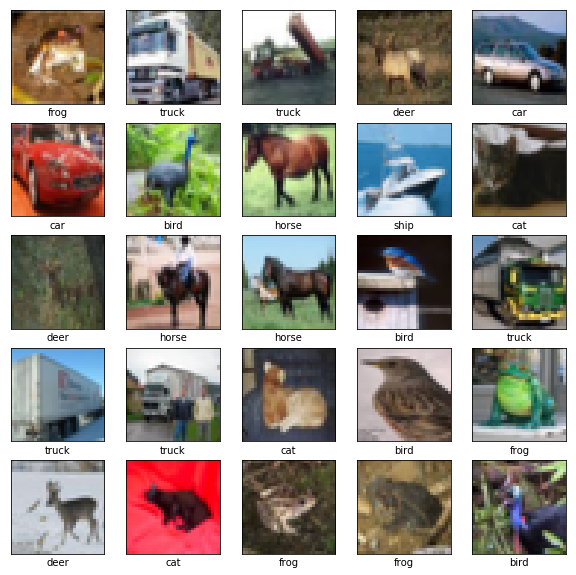

In [20]:
#Data set

cifar10 = keras.datasets.cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

train_labels=train_labels.reshape(50000,)
test_labels=test_labels.reshape(10000,)

class_names = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

#Some examples
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])

In [21]:
#how many of each class
lab=list(train_labels)
[print(lab.count(i),class_names[i]) for i in range(10)];

5000 plane
5000 car
5000 bird
5000 cat
5000 deer
5000 dog
5000 frog
5000 horse
5000 ship
5000 truck


In [22]:
#rescale the images, such that each channel is in the range [-1,1] instead of 0 to 255
#One can try rescaling it differently, for example in range[0,1] as was done for Fashion-MNIST above
train_images_scaled = train_images / 255.0
test_images_scaled = test_images / 255.0
train_images_scaled=2*train_images_scaled-1.0
test_images_scaled=2*test_images_scaled-1.0
#(Note that this means you have to rescale back to positive numbers plot the images later)

In [23]:
#Import the Keras layers etc
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, Dropout,BatchNormalization, UpSampling2D
from tensorflow.python.keras.callbacks import Callback
from tensorflow.python.keras import regularizers

Construct your network:

<code>
model=Sequential()
model.add(
</code>
.
.
.
<code>
model.add(Dense(10, activation='softmax'))
model.summary()
</code>

Compile 
<code>
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
</code>
train
<code>
model.fit(train_images_scaled, train_labels, epochs = 10,validation_split=0.1,callbacks = [my_callback])
</code>
and test
<code>
test_loss, test_acc = model.evaluate(test_images_scaled, test_labels)
print('Test accuracy:', test_acc)
</code>    

In [24]:
# mini-VGG net

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(1, 1), padding='same', activation=None, input_shape=(32,32,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='valid')) # Now it is halved (16, 16, 8)
model.add(Activation("relu"))

model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation=None, input_shape=(16,16,32)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='valid')) # Now it is halved (8,8,16)

model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), padding='same', activation=None, input_shape=(8,8,64))) #(8,8,32)
model.add(Activation("relu"))

model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), padding='same', activation=None, input_shape=(8,8,128))) #(8,8,32)
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='valid')) # Now it is halved (8,8,16)

model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1, 1), padding='same', activation=None, input_shape=(4,4,128))) #(8,8,32)
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='valid')) ##(4,4,4)

model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(1, 1), padding='same', activation=None, input_shape=(2,2,256))) #(8,8,32)
model.add(BatchNormalization())
model.add(Activation("relu"))
#model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='valid')) ##(8,8,128)

model.add(AveragePooling2D(pool_size=(2,2), strides=(1,1), padding='valid'))
model.add(Flatten(input_shape=(1,1,512)))
#model.add(Dense(200, activation="relu"))
#model.add(Dropout(rate=0.1)) # rate is fraction to drop
model.add(Dense(10, activation="softmax"))

my_callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=0)
                                            
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(train_images_scaled, train_labels, epochs = 10, validation_split=0.1, callbacks = [my_callback])
model.summary()

KeyboardInterrupt: 

In [ ]:
model.summary()

test_loss, test_acc = model.evaluate(test_images_scaled, test_labels)

print('Test accuracy:', test_acc)

#network predicted output label, in terms of a probability  
predictions = model.predict(test_images_scaled)

### The classification for a subset of the test images could look something like this.
Don't run the cell below until you have a trained and tested network. 

In [ ]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red 
num_rows = 10
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

## Extra challenge

In [ ]:
# Can your network get this image of a dog? 

pic_index = 24;

# plot the test picture
plt.figure()
plt.imshow(test_images[pic_index])
plt.grid(False)
plt.show()

print("Predicted to be:")
print(class_names[np.argmax(predictions[pic_index])])
print("Actually is:")
print(class_names[test_labels[pic_index]])

# Assignment 2 / Cifar-100

Somthing we discussed in connection with the introduction to softmax output was that the one should be careful with interpreting the latter as representing a confidence in the class prediction. As a teaser to this problem let's try  out how your network classifies images from the Cifar-100 dataset. This contains the same type of images but in 100 other classes.    

In [ ]:
cifar100 = keras.datasets.cifar100

(train_images100, train_labels100), (test_images100, test_labels100) = cifar100.load_data()

train_labels100=train_labels100.reshape(50000,)
test_labels100=test_labels100.reshape(10000,)

#note that you need to have the provided file 'Cifar_100_names' available
import pickle
with open('Cifar_100_names', 'rb') as fo:
    dict = pickle.load(fo, encoding='bytes')
name_list=dict[b'fine_label_names']
class_names100=[name_list[i].decode('utf-8') for i in range(100)]


#Some examples
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images100[i], cmap=plt.cm.binary)
    plt.xlabel(class_names100[train_labels100[i]])

In [ ]:
train_images100_scaled = train_images100 / 255.0
test_images100_scaled = test_images100 / 255.0
train_images100_scaled=2*train_images100_scaled-1.0
test_images100_scaled=2*test_images100_scaled-1.0

In [ ]:
#run this using your own network trained on Cifar-10
predictions = model.predict(test_images100_scaled)

__Plot some examples using the code below. The network obviously cannot get anything right (it's not even the same classes). But it is still quite confident about its predictions!__

In [ ]:
def plot_image10_100(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names100[true_label]),
                                color=color)
    
    
num_rows = 3
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(12, 12))
for i in range(num_images):
  plt.subplot(num_rows,num_cols, i+1)
  plot_image10_100(i, predictions, test_labels100, test_images100)

## Transfer learning
 (Time consuming without a GPU)

Let's try to build a better classifier for Cifar-100. Here we suggest to use a neat trick, _transfer learning,_ that uses a deep pretrained network as a base for the classifier. The idea is that the deep CNN has already learned good filters for image recognition that we can use as a first processing on to which we then add a single (or a few) layers that we train on our particular dataset. (Keeping the parameters of the base fixed)  We will use [VGG16](http://www.robots.ox.ac.uk/~vgg/practicals/cnn/index.html), trained on the [ImageNet](https://en.wikipedia.org/wiki/ImageNet) dataset, as a base. Most of the code is provided below. You are encouraged to play around with the input dimensions, the number of trainable layers etc. Also, you can compare to training a network from scratch on this dataset. There are also other pretrained networks to import, such as resnet50, etc. 

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
vgg=VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
#Here the pre-trained weights are imported, the end layers are removed, and the input shape specified
#We have 32x32 images, but because the network does a successive reduction of resolution we cannot specify 
#that as input shape, instead we need to scale up the input.

In [ ]:
model=Sequential()
model.add(UpSampling2D(size=(2,2),input_shape=(32,32,3))) #scale up resolution by interpolation
model.add(UpSampling2D((2,2)))
model.add(vgg)
model.add(Flatten())
model.add(Dense(100, activation="softmax"))

#the VGG layers are not trained
for layer in vgg.layers:
    layer.trainable = False
    
model.summary()

<code> model.compile </code>

<code> model.fit </code>

This is pretty slow. Even though there are not that many trainable parameters, the forward progagation is quite heavy. 

In [ ]:
my_callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=0)
                                            
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(train_images100_scaled, train_labels100, epochs = 1, validation_split=0.1, callbacks = [my_callback])

In [ ]:
test_loss, test_acc = model.evaluate(test_images100_scaled, test_labels100)

print('Test accuracy:', test_acc)

#We get an accuracy of about 50% on the test set. Not so great, but more of a point of principle. 

<code> predictions = model.predict(test_images100_scaled[0:20]) </code>

### Plot the classification on a selection of images.

In [ ]:
def plot_image100(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names100[predicted_label],
                                100*np.max(predictions_array),
                                class_names100[true_label]),
                                color=color)


num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(12, 12))
for i in range(num_images):
  plt.subplot(num_rows,num_cols, i+1)
  plot_image100(i, predictions, test_labels100, test_images100)